In [8]:
! pip install -q kaggle
import os
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download uom190346a/e-commerce-customer-behavior-dataset
! mkdir e_commerce
! unzip e-commerce-customer-behavior-dataset.zip -d e_commerce

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/uom190346a/e-commerce-customer-behavior-dataset
License(s): CC0-1.0
e-commerce-customer-behavior-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘e_commerce’: File exists
Archive:  e-commerce-customer-behavior-dataset.zip
replace e_commerce/E-commerce Customer Behavior - Sheet1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import plotly.express as px

In [24]:
data = pd.read_csv('/content/e_commerce/E-commerce Customer Behavior - Sheet1.csv')
data.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied


In [25]:
grouped_df = data.groupby('City', as_index=False)['Total Spend'].sum()

print(grouped_df)

            City  Total Spend
0        Chicago      28993.2
1        Houston      25919.9
2    Los Angeles      47524.0
3          Miami      40042.6
4       New York      68737.1
5  San Francisco      84666.8


In [26]:
# Static city coordinates (latitude, longitude) for common cities
city_coords = {
    'Houston': (29.7604, -95.3698),
    'Los Angeles': (34.0522, -118.2437),
    'Miami': (25.7617, -80.1918),
    'New York': (40.7128, -74.0060),
    'San Francisco': (37.7749, -122.4194)
}

# Function to get coordinates from predefined dictionary
def get_lat_long_static(city_name):
    return city_coords.get(city_name, (None, None))

# Apply the static coordinates function
grouped_df['Latitude'], grouped_df['Longitude'] = zip(*grouped_df['City'].apply(get_lat_long_static))

print(grouped_df)


            City  Total Spend  Latitude  Longitude
0        Chicago      28993.2       NaN        NaN
1        Houston      25919.9   29.7604   -95.3698
2    Los Angeles      47524.0   34.0522  -118.2437
3          Miami      40042.6   25.7617   -80.1918
4       New York      68737.1   40.7128   -74.0060
5  San Francisco      84666.8   37.7749  -122.4194


In [27]:
# Create a geographical scatter plot using Plotly
fig = px.scatter_geo(grouped_df,
                     lat='Latitude',
                     lon='Longitude',
                     size='Total Spend',
                     hover_name='City',
                     color='Total Spend',
                     color_continuous_scale='reds',
                     projection='natural earth',
                     title='Total Spend by City')

# Show the plot
fig.show()


In [28]:
data = data.drop(columns=['Customer ID'])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Gender', 'City', 'Membership Type', 'Satisfaction Level'], drop_first=True, dtype=int)

# Convert Discount Applied to numeric
data['Discount Applied'] = data['Discount Applied'].astype(int)

data.head()

,Age,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Satisfaction Level_Satisfied,Satisfaction Level_Unsatisfied
0,29,1120.20,14,4.6,1,25,0,0,0,0,1,0,1,0,1,0
1,34,780.50,11,4.1,0,18,1,0,1,0,0,0,0,1,0,0
2,43,510.75,9,3.4,1,42,0,0,0,0,0,0,0,0,0,1
3,30,1480.30,19,4.7,0,12,1,0,0,0,0,1,1,0,1,0
4,27,720.40,13,4.0,1,55,1,0,0,1,0,0,0,1,0,1


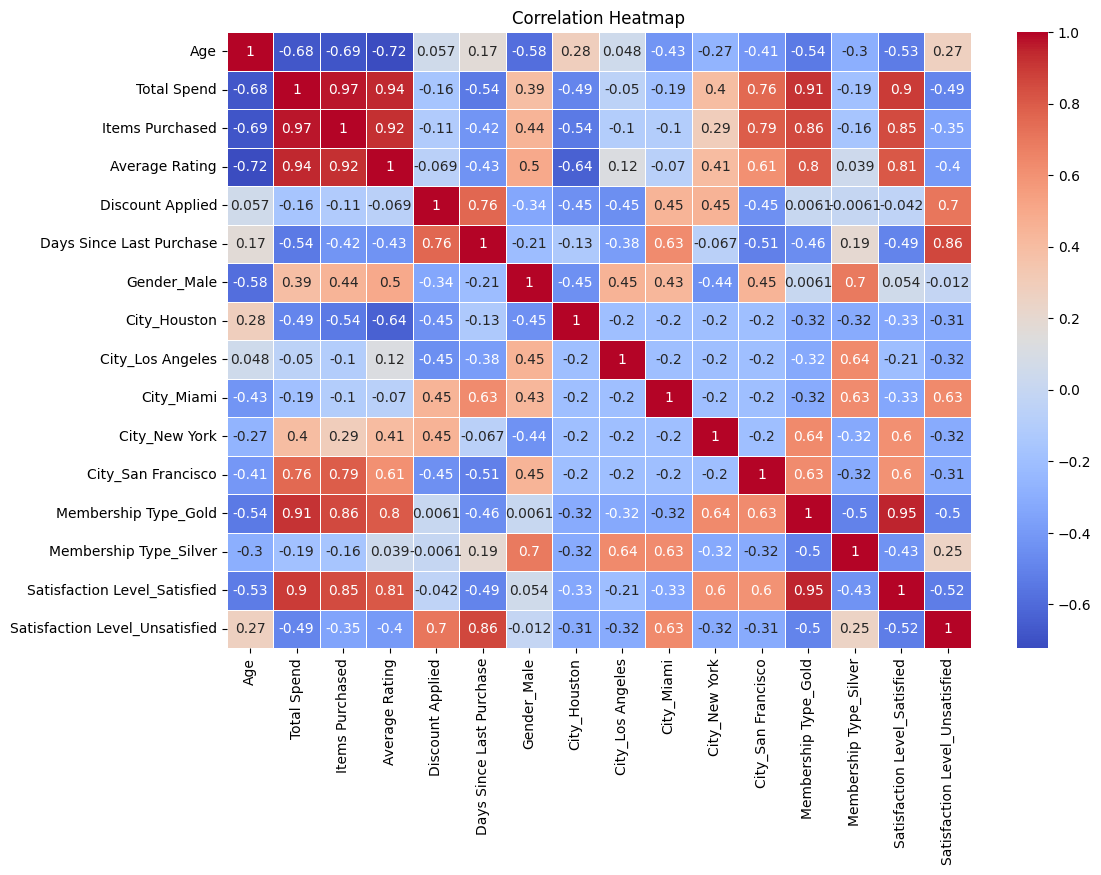

In [29]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [30]:
# Split the data
X = data.drop(columns=['Items Purchased'])  # Features
y = data['Items Purchased']  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
import statsmodels.api as sm

# Adding a constant to the model (for intercept)
X_train_sm = sm.add_constant(X_train)

# Create Poisson Regression model
poisson_model = sm.GLM(y_train, X_train_sm, family=sm.families.Poisson())

# Fit the model
poisson_results = poisson_model.fit()

# View the model summary
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Items Purchased   No. Observations:                  280
Model:                            GLM   Df Residuals:                      268
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -607.92
Date:                Sat, 26 Oct 2024   Deviance:                       5.1135
Time:                        22:31:43   Pearson chi2:                     5.11
No. Iterations:                     4   Pseudo R-squ. (CS):             0.7226
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [32]:
# Add constant to the test set
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = poisson_results.predict(X_test_sm)

# Evaluate predictions by comparing them to actual values
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, you can print RMSE (Root Mean Squared Error)
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 0.3586918032784112
Root Mean Squared Error: 0.5989088438806119


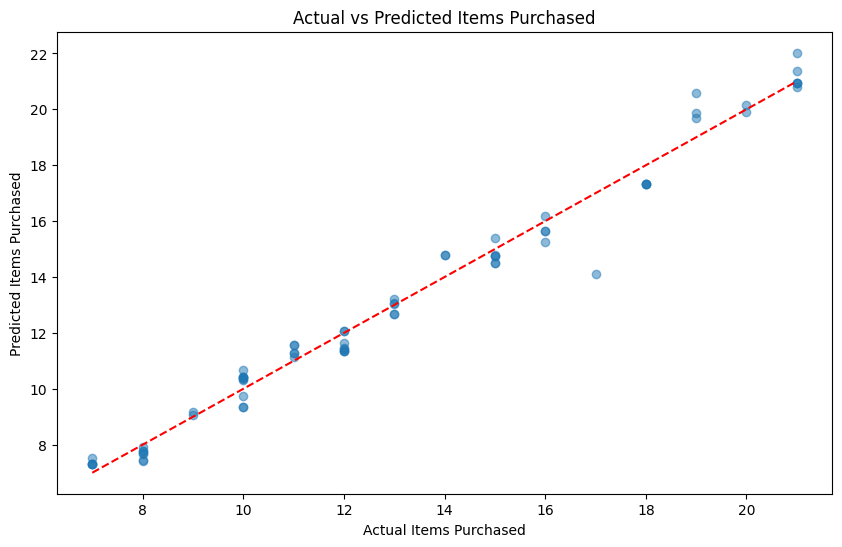

In [33]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Items Purchased')
plt.ylabel('Predicted Items Purchased')
plt.title('Actual vs Predicted Items Purchased')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of perfect prediction
plt.show()


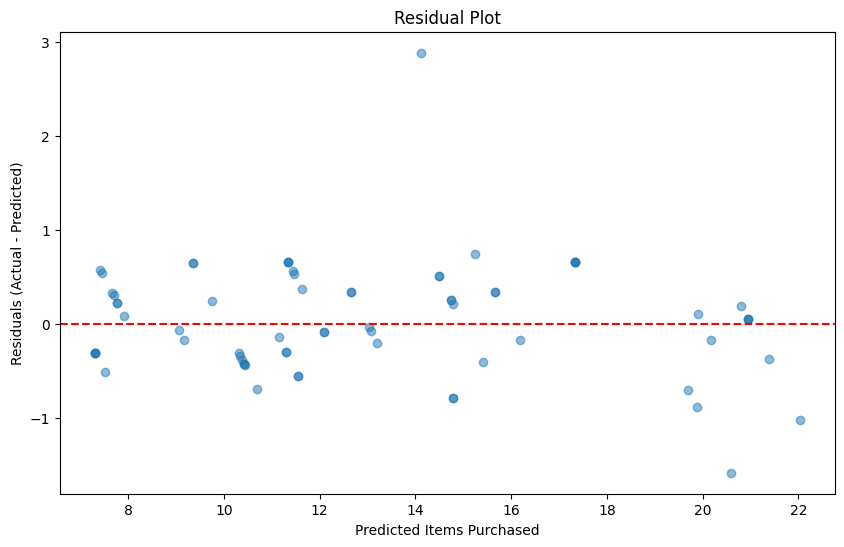

In [34]:
# Calculate residuals (actual - predicted)
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Items Purchased')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()


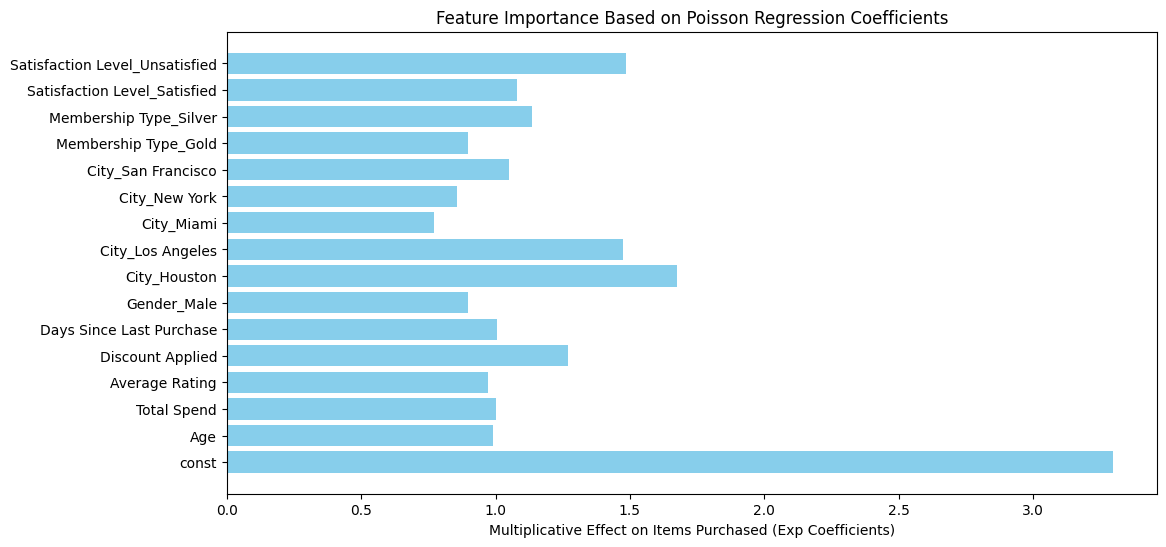

In [35]:
import numpy as np

# Get feature names (assuming you've added a constant term, so drop it from visualization)
feature_names = X_train_sm.columns

# Exponentiate coefficients
exp_coef = np.exp(poisson_results.params)

# Plot coefficient magnitudes
plt.figure(figsize=(12, 6))
plt.barh(feature_names, exp_coef, color='skyblue')
plt.xlabel('Multiplicative Effect on Items Purchased (Exp Coefficients)')
plt.title('Feature Importance Based on Poisson Regression Coefficients')
plt.show()


In [36]:
# Deviance: Lower deviance means better fit
print(f"Deviance: {poisson_results.deviance}")

# Check residuals
residuals = poisson_results.resid_response

# Coefficients for the model
print(poisson_results.params)

# Exponentiated coefficients to interpret as multiplicative factors
exp_coef = np.exp(poisson_results.params)
print(exp_coef)


Deviance: 5.113466856156917
const                             1.192855
Age                              -0.010895
Total Spend                       0.001573
Average Rating                   -0.029791
Discount Applied                  0.238945
Days Since Last Purchase          0.004611
Gender_Male                      -0.106245
City_Houston                      0.516526
City_Los Angeles                  0.387932
City_Miami                       -0.260323
City_New York                    -0.156569
City_San Francisco                0.049452
Membership Type_Gold             -0.107117
Membership Type_Silver            0.127609
Satisfaction Level_Satisfied      0.078436
Satisfaction Level_Unsatisfied    0.395514
dtype: float64
const                             3.296479
Age                               0.989164
Total Spend                       1.001574
Average Rating                    0.970648
Discount Applied                  1.269909
Days Since Last Purchase          1.004622
Gender_Male